In [46]:
from my_functions import*

In [47]:
file1= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/MuonTree_ZB_0.root") #opening the Root file with Uproot 
file2=uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root")

In [48]:
MuonTree_ZeroBias=file1["MuonTree;1"]
MuonTree_Zmumu=file2["MuonTree_Zmumu"]
ZeroBias_pt=MuonTree_ZeroBias["muon_pt"].array()


nmin=0
nmax=2000
dr_min=0.2
dr_max=0.6

ZeroBias_eta=energy_cut(MuonTree_ZeroBias["LVL1Muon_et"].array(), MuonTree_ZeroBias["LVL1Muon_eta"].array(), 14)[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["LVL1Muon_et"].array(), MuonTree_ZeroBias["LVL1Muon_phi"].array(), 14)[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["LVL1Muon_et"].array(), MuonTree_ZeroBias["LVL1Muon_et"].array(), 14)[nmin:nmax]


#Select quality 0 Z->mumu
Zmumu_pt=MuonTree_Zmumu["LVL1Muon_et"].array()[nmin:nmax]
Zmumu_eta=MuonTree_Zmumu["LVL1Muon_eta"].array()[nmin:nmax]
Zmumu_phi=MuonTree_Zmumu["LVL1Muon_phi"].array()[nmin:nmax]
#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)


energy_cut: Only 0.07% of the events have survived the cut with a lower cut of 14 and no upper cut
energy_cut: Only 0.07% of the events have survived the cut with a lower cut of 14 and no upper cut
energy_cut: Only 0.07% of the events have survived the cut with a lower cut of 14 and no upper cut


100%|██████████| 2000/2000 [00:01<00:00, 1970.72it/s]


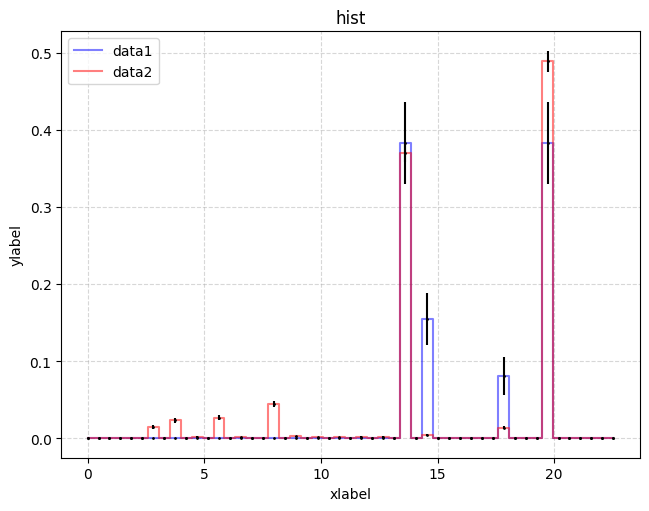

In [49]:
coolplot([ZeroBias_pt, Zmumu_pt], np.linspace(0,23, 50))

In [50]:
res1=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [nmin,nmax])
res2=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max, [nmin,nmax])

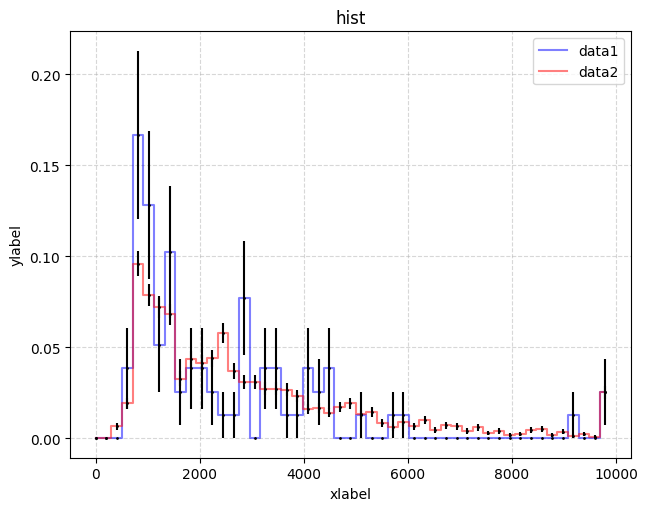

In [51]:
coolplot([res1,res2], np.linspace(0,10000,50))

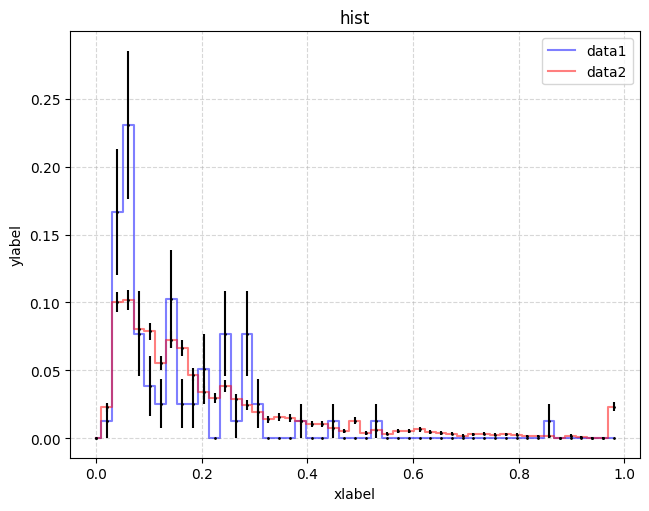

In [59]:
ratio1=ak.flatten(res1)/(1000*ak.flatten(ZeroBias_pt))
ratio2=ak.flatten(res2)/(1000*ak.flatten(Zmumu_pt))

coolplot([ratio1,ratio2], np.linspace(0,1,50))

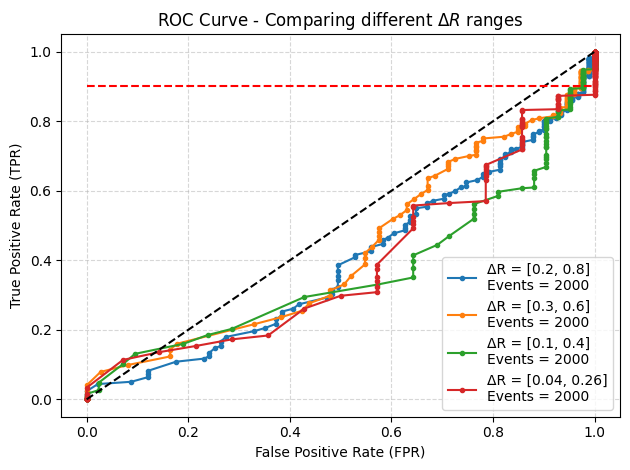

[[<Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='219 * float64'>,
  <Array [0, 0, 0, 0, 0, 0.00222, ..., 0.999, 1, 1, 1, 1, 1] type='219 * float64'>],
 [<Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='219 * float64'>,
  <Array [0, 0, 0, 0, 0, ..., 0.999, 0.999, 0.999, 1, 1] type='219 * float64'>],
 [<Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='219 * float64'>,
  <Array [0, 0, 0, 0, 0, ..., 0.999, 0.999, 0.999, 0.999, 1] type='219 * float64'>],
 [<Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='219 * float64'>,
  <Array [0, 0, 0, 0, 0, 0.000799, ..., 1, 1, 1, 1, 1, 1] type='219 * float64'>]]

In [60]:
dr_min=[0.2,0.3,0.1,0.04]
dr_max=[0.8,0.6,0.4,0.26]

plot_ROC_curve(MuonTree_Zmumu,MuonTree_ZeroBias,Zmumu_pt,Zmumu_eta,Zmumu_phi,ZeroBias_pt,ZeroBias_eta,ZeroBias_phi,
               [nmin,nmax],[nmin,nmax],np.linspace(0,1000,5*int(np.sqrt(nmax-nmin))),dr_min,dr_max)

In [58]:
ratio1

<Array [0.0788, 0.127, 0.305, nan, ..., 0.26, nan, 0.065] type='136 * float64'>